In [14]:
import json
import re
import warnings
from collections import Counter, defaultdict

import gensim
import gensim.corpora as corpora
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import pyLDAvis
import pyLDAvis.gensim
import seaborn as sns
import spacy
import scipy.stats
from collections import OrderedDict
from bokeh.io import output_notebook
from bokeh.models import Label
from bokeh.plotting import figure, output_file, show
from gensim.models import CoherenceModel, LsiModel, HdpModel, LdaModel
from gensim.utils import simple_preprocess
from gensim.test.utils import datapath
from matplotlib.patches import Rectangle
from matplotlib.ticker import FuncFormatter
from nltk.corpus import stopwords
from nltk.corpus import wordnet as wn
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.manifold import TSNE
from wordcloud import STOPWORDS, WordCloud

## Run in terminal with the size wanted 
# python3 pushshift_comments.py 10

warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

# import training data

df = pd.read_csv('comments.csv', encoding='utf8')

# Cleaning up the comments
# nltk.download('stopwords')  # (run python console)
# nltk.download('wordnet')  # (run python console)
# python3 -m spacy download en  # (run in terminal)

# Extracting URLs: external links often informative, but they add unwanted noise to our NLP model
# Strip out hyperlinks and copy thme in a new column URL

# Find URL
def find_URL(comment):
    return re.findall(r'((?:https?:\/\/(?:www\.)?|(?:pic\.|www\.)(?:\S*\.))(?:\S*\/))', comment)

# apply the function on the body column
df['URL'] = df.body.apply(find_URL)

# create a colummn with pre-processed try:
df['clean_body'] = [re.sub(r"((?:https?:\/\/(?:www\.)?|(?:pic\.|www\.)(?:\S*\.))(?:\S*\/))",'', x) for x in df['body']]

In [15]:
# Find all internal hyphen words and consider them as full words (technical vocabulary)
df['clean_body'] = [re.sub(r'([a-zA-Z]+)(-)([a-zA-Z]+)', r'\g<1>\g<3>', x) for x in df['clean_body']]


In [16]:
# Standardizing the informal language of comments
# NLTK Stop words
stop_words = stopwords.words('english')
#stop_words.extend(['home', 'week', 'actual'])

#We specify the stemmer or lemmatizer we want to use
word_rooter = nltk.stem.snowball.PorterStemmer(ignore_stopwords=False).stem
wordnet_lemmatizer = WordNetLemmatizer()

def clean_comment(comment, bigrams=False, lemma=False, allowed_postags=['NOUN', 'ADJ', 'VERB']):
    comment = comment.lower() # ? consider to make general the name of companies or decives
    comment = re.sub('&gt', ' ', comment) # remove all copied text into a comment '&gt'
    comment = re.sub('[^\s\w]', ' ', comment) # strip out everything (punctuation) that is not Unicode whitespace or word character
    comment = re.sub('[0-9]+', ' ', comment) # remove digits

    # remove stop_words
    comment_token_list = [word for word in comment.strip().split() if word not in stop_words]
    
    # remove one character word
    comment_token_list = [word for word in comment_token_list if len(word) > 1]
    
    # keeps word meaning
    if lemma == True:
        # Initialize spacy 'en' model, keeping only tagger component (for efficiency)
        nlp = spacy.load('en', disable=['parser', 'ner'])
        # https://spacy.io/api/annotation
        comment_text = nlp(' '.join(comment_token_list))
        comment_token_list = [token.lemma_ for token in comment_text if token.pos_ in allowed_postags]
        #comment_token_list = [wordnet_lemmatizer.lemmatize(word) for word in comment_token_list]
    
    # harsh to the root of the word
    else:
        comment_token_list = [word_rooter(word) for word in comment_token_list]

    if bigrams:
        comment_token_list = bigram[comment_token_list]
    
    comment = ' '.join(comment_token_list)
    
    return comment

In [17]:
# Apply function to clean the comment
df['clean_body'] = df.clean_body.apply(clean_comment, lemma=True)

In [18]:
# function to plot most frequent terms or vice versa
def freq_words(x, ascending=False, terms = 30):
  all_words = ' '.join([text for text in x])
  all_words = all_words.split()

  fdist = nltk.FreqDist(all_words)
  words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())})

  # selecting top most frequent words
  d = words_df.sort_values("count", ascending=ascending)
  plt.figure(figsize=(20,5))
  ax = sns.barplot(data=d[:terms], x= "word", y = "count")
  ax.set(ylabel = 'Count')
  plt.xticks(rotation=45)
  plt.show()

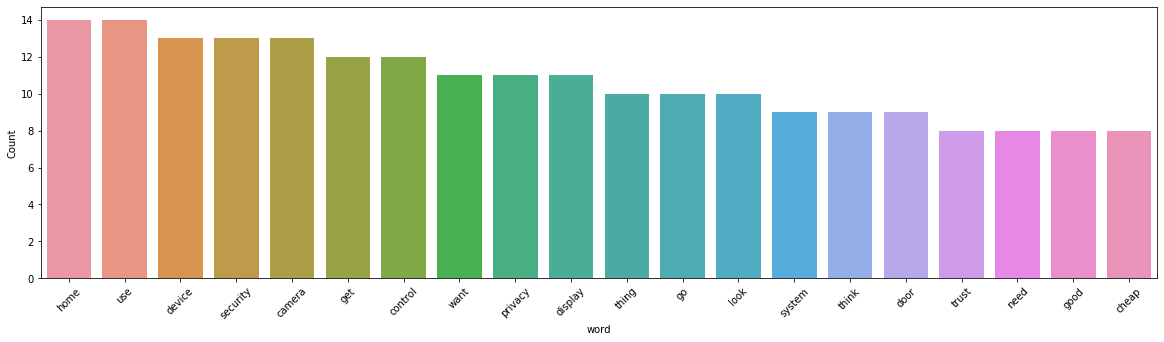

In [19]:
freq_words(df['clean_body'], False, 20)

In [20]:
def comment2token(comments):
    '''
    Return sequence (stream, generator) of sentences,
    with each sentence a list of tokens
    '''
    return [comment.split() for comment in comments]

comment_token_list = comment2token(df['clean_body'])

# Train Bigram and Trigram Models
# higher threshold fewer phrases.
bigram = gensim.models.Phrases(comment_token_list, min_count=3, threshold=20)

# Frequency of n-gram words
dist = nltk.FreqDist(
    [word for comment in bigram[comment_token_list] for word in comment if '_' in word])

# Sort frequency
print('Sorted trigrams: \n')
print(sorted(dist.items(), key=lambda x: x[1], reverse=True))
print('-'*20)

Sorted trigrams: 

[('home_automation', 5)]
--------------------


In [21]:
# Create a new columns with tokens
df['token_text'] = [[word for word in comment.split()] for comment in df['clean_body']]

In [22]:
# Add Wikipedia corpus
with open('train_wiki.json', 'r') as f:
    train_wiki = json.load(f)

link = []
category = []
body_par = []

for item in train_wiki:
    link.append(item['link'])
    category.append(item['category'])
    body_par.append(item['body_par'])

wiki_text= []
for elm in body_par:
    wiki_text.append(' '.join(elm))

wiki_text = pd.DataFrame({'wiki_text': wiki_text})

# Apply function to clean the comment
wiki_text['wiki_clean'] = wiki_text.wiki_text.apply(clean_comment, lemma=True)
wiki_text['token_text'] = [[word for word in comment.split()] for comment in wiki_text['wiki_clean']]

In [23]:
# comment = df['token_text']
comment = pd.concat([wiki_text['token_text'], df['token_text']], ignore_index=True)

In [24]:
# Create Dictionary
dictionary = corpora.Dictionary(comment)

# Term Document Frequency >> (id, freq) for each page
corpus = [dictionary.doc2bow(text) for text in comment]

# print('\nPrint words and frequencies in the first comment:\n')
# print([[(dictionary[id], freq) for id, freq in page] for page in corpus[3:4]])
# print('-' * 20)

Small tfidf:

property: 0.06932425814500634
general: 0.06932425814500634
other: 0.06932425814500634
project: 0.06932425814500634
follow: 0.07109819182711717
define: 0.07233429482394407
link: 0.07233429482394407
main: 0.07233429482394407
notion: 0.07233429482394407
consider: 0.07468237659562438

Large tfidf:

actual: 0.7062231854820462
network: 0.6720261166164521
door: 0.6631223611359053
lock: 0.6133531260245713
mycroft: 0.5850415758804739
display: 0.5557773086535776
system: 0.5004881729715952
concerned: 0.47842009429075355
alexa: 0.47842009429075355
switch: 0.46218573984307637


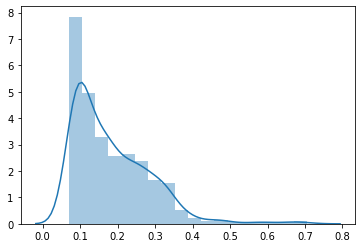

In [69]:
# TF-IDF model as pre-processing step
cv = CountVectorizer()
# comment_token_vector = cv.fit_transform(df['clean_body'])
comment_token_vector = cv.fit_transform(pd.concat([wiki_text['wiki_clean'],
                                                   df['clean_body']], ignore_index=True))

# Compute the IDF values
tfidf_transformer = TfidfTransformer(smooth_idf=True, use_idf=True)
tfidf_transformer.fit(comment_token_vector)

# Compute the TFIDF score (new unseen dataset)
count_vector = cv.transform(df['clean_body'])
tfidf_vector = tfidf_transformer.transform(count_vector)

# Check if it makes sense
feature_names = np.array(cv.get_feature_names())

# Remove the words that do not appear in the unseen dataset
zero_index = np.where(tfidf_vector.max(0).toarray()[0] == 0)[0]
feature_names = np.delete(feature_names, zero_index)
tfidf_vector = np.delete(tfidf_vector.max(0).toarray()[0], zero_index)

# max(0) equal max by columns
# argsort: return the indices that would sort an array
# sorted_tfidf_index = tfidf_vector.max(0).toarray()[0].argsort()
sorted_tfidf_index = tfidf_vector.argsort()

# Small: words commonly used across all documents and rarely used 
# in the particular document/low frequency term
print('Small tfidf:\n')
for i in sorted_tfidf_index[:10]:
    print('{}: {}'.format(feature_names[i],
                                           tfidf_vector[i]))

print('\nLarge tfidf:\n')
for i in sorted_tfidf_index[:-11:-1]:
    print('{}: {}'.format(feature_names[i],
                                           tfidf_vector[i]))
    
sns.distplot(tfidf_vector)
# CONSIDER: find score threshold where words are deleted

In [70]:
# Find the optimal number of topics
def LdaMallet_coherence_values(dictionary, corpus, texts, limit, start = 2, step = 3):
    '''
    Compute c_v coherence for various number of topics
    
    Parameters:
    ---------
    dictionary: Gensim dictionary
    corpus: Gensim corpus
    texts: list of input texts
    limit: max num of topics
    
    Returns:
    ---------
    model_list: list of LDA topic models
    coherence_values: corresponding to the LDA model
    '''
    
    mallet_path = 'mallet-2.0.8/bin/mallet'
    
    coherence_values = []
    model_list = []

    for num_topics in range(start, limit, step):
        print('Running model with number of topics: ', num_topics)
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus = corpus, num_topics = num_topics, id2word = dictionary)
        model_list.append(model)

        coherencemodel = CoherenceModel(model = model, texts = texts, dictionary = dictionary, coherence = 'c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

def LDA_coherence_values(dictionary, corpus, texts, limit, chunksize = 100, start=2, step=3):
    '''
    Compute c_v coherence for various number of topics

    Parameters:
    ---------
    dictionary: Gensim dictionary
    corpus: Gensim corpus
    texts: list of input text 
    chunksize: number of documents to be used in each training chunk
    limit: max num of topics

    Returns:
    ---------
    model_list: list of LDA topic
    coherence_values: corresponding to the LDA model
    '''

    coherence_values = []
    model_list = []

    for num_topics in range(start, limit, step):
        print('Running model with number of topics: ', num_topics)
        model = gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=dictionary,
                                                num_topics=num_topics, random_state=100, 
                                                update_every=1, chunksize=100, passes=10, 
                                                alpha='auto', per_word_topics=True)
        
        model_list.append(model)

        coherencemodel = CoherenceModel(model = model, texts = texts, dictionary = dictionary, coherence = 'c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [71]:
model_list, coherence_values = LDA_coherence_values(dictionary=dictionary, corpus=corpus, 
                                                          texts=comment, start=2, limit=20, step=1)

Running model with number of topics:  2
Running model with number of topics:  3
Running model with number of topics:  4
Running model with number of topics:  5
Running model with number of topics:  6
Running model with number of topics:  7
Running model with number of topics:  8
Running model with number of topics:  9
Running model with number of topics:  10
Running model with number of topics:  11
Running model with number of topics:  12
Running model with number of topics:  13
Running model with number of topics:  14
Running model with number of topics:  15
Running model with number of topics:  16
Running model with number of topics:  17
Running model with number of topics:  18
Running model with number of topics:  19


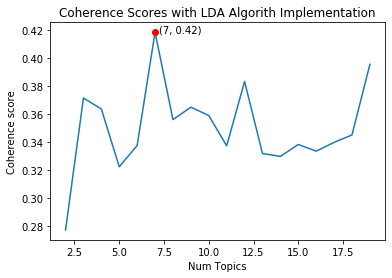

In [72]:
limit = 20
start=2
step=1
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.plot(x[np.argmax(coherence_values)], max(coherence_values), 'or')
plt.text(x[np.argmax(coherence_values)]+0.2, max(coherence_values), 
         r'({}, {})'.format(x[np.argmax(coherence_values)], np.round(max(coherence_values), 2)))
plt.xlabel('Num Topics')
plt.ylabel('Coherence score')
plt.title('Coherence Scores with LDA Algorith Implementation')
# plt.savefig('output/Topics_Coher_LDA_Model_page')
plt.show()

In [73]:
print('\nLDA model: \n')
for num, cv in zip(x, coherence_values):
    print('Nun Topics =', num, ' has Coherence Value of', round(cv, 4))
print('-'*20)


LDA model: 

Nun Topics = 2  has Coherence Value of 0.277
Nun Topics = 3  has Coherence Value of 0.3714
Nun Topics = 4  has Coherence Value of 0.3635
Nun Topics = 5  has Coherence Value of 0.3222
Nun Topics = 6  has Coherence Value of 0.3374
Nun Topics = 7  has Coherence Value of 0.4185
Nun Topics = 8  has Coherence Value of 0.3559
Nun Topics = 9  has Coherence Value of 0.3648
Nun Topics = 10  has Coherence Value of 0.3589
Nun Topics = 11  has Coherence Value of 0.3371
Nun Topics = 12  has Coherence Value of 0.3832
Nun Topics = 13  has Coherence Value of 0.3317
Nun Topics = 14  has Coherence Value of 0.3296
Nun Topics = 15  has Coherence Value of 0.3381
Nun Topics = 16  has Coherence Value of 0.3334
Nun Topics = 17  has Coherence Value of 0.3396
Nun Topics = 18  has Coherence Value of 0.345
Nun Topics = 19  has Coherence Value of 0.3955
--------------------


In [89]:
# Extract the model base on the topic number
def model_extract(num_topics):
    '''
    Input: num_topics (int)
    '''
    # get number of topics
    num, _ = zip(*list(zip(x,coherence_values)))
    model = model_list[[i for i in range(len(num)) if num[i] == num_topics][0]]
    
    return model

model = model_extract(4)

In [113]:
# save model to disk
# temp_file = datapath("TrainedModel")
# model.save(temp_file)
# Load a potentially pretrained model from disk.
# lda = LdaModel.load(temp_file)

In [90]:
model_topics = model.show_topics(num_topics=4, num_words=10,formatted = False)

In [126]:
print('\n LDA topics: \n')
for topic, keyword in model.print_topics(num_words=20):
    print('Topic: ', topic)
    print('Keywords: ', keyword)
print('-'*20)


 LDA topics: 

Topic:  0
Keywords:  0.012*"display" + 0.009*"camera" + 0.007*"cheap" + 0.007*"home" + 0.007*"use" + 0.006*"security" + 0.006*"think" + 0.006*"go" + 0.006*"alert" + 0.006*"get" + 0.005*"lead" + 0.005*"replace" + 0.005*"door" + 0.005*"switch" + 0.005*"open" + 0.005*"time" + 0.005*"need" + 0.005*"privacy" + 0.004*"battery" + 0.004*"app"
Topic:  1
Keywords:  0.060*"security" + 0.017*"system" + 0.009*"referent" + 0.007*"example" + 0.006*"include" + 0.006*"home" + 0.006*"access" + 0.006*"people" + 0.006*"refer" + 0.006*"computer" + 0.005*"right" + 0.005*"mean" + 0.005*"environment" + 0.005*"door" + 0.004*"information" + 0.004*"want" + 0.004*"device" + 0.004*"control" + 0.004*"change" + 0.004*"state"
Topic:  2
Keywords:  0.058*"privacy" + 0.029*"information" + 0.012*"individual" + 0.012*"right" + 0.010*"personal" + 0.008*"use" + 0.008*"control" + 0.007*"private" + 0.006*"self" + 0.006*"public" + 0.006*"user" + 0.006*"law" + 0.006*"other" + 0.005*"social" + 0.005*"include" + 0

In [92]:
# Visualize the topics
# mds='TSNE'
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(model, corpus, dictionary)
vis


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.114602  0.093570       1        1  43.921917
3      0.125487  0.060067       2        1  31.830215
1     -0.045419 -0.106205       3        1  17.324312
0      0.034534 -0.047432       4        1   6.923555, topic_info=     Category        Freq         Term       Total  loglift  logprob
1418  Default  104.000000        trust  104.000000  30.0000  30.0000
733   Default   67.000000     security   67.000000  29.0000  29.0000
618   Default  152.000000      privacy  152.000000  28.0000  28.0000
801   Default   26.000000       system   26.000000  27.0000  27.0000
412   Default   84.000000  information   84.000000  26.0000  26.0000
...       ...         ...          ...         ...      ...      ...
527    Topic4    1.594296      network    8.445949   1.0030  -5.5236
733    Topic4    2.541246     security   67.138435  -0.6039  -5.0574
877    Topic4    1.560250         want   12.082413   0.6233  -5.5452
618    Topic4    1.797926      privacy  152.838623  -1.7725  -5.4034
182    Topic4    1.441010      control   30.952896  -0.3969  -5.6247

[260 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
0         1  0.899281  ability
0         4  0.112410  ability
4         1  0.640361   access
4         3  0.320181   access
4         4  0.053363   access
...     ...       ...      ...
877       4  0.165530     want
882       1  0.724219      way
882       2  0.181055      way
882       3  0.060352      way
1584      3  0.715089    zwave

[375 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 4, 2, 1])

In [129]:
# Extract the topic with highest security, trust and privacy

def relevent_topic(num_topics, query):
    '''
    Input:
        > num_topics: integer
        > query: term string
    '''
    print('{} topics:\n'.format(query.upper()))
    relevant = [(num, dist) for num, dist in model.show_topics(num_words=20, num_topics = num_topics) if len(re.findall(query, dist)) != 0]
    
    for i in relevant:
        print('Topic: {}'.format(i[0]))
        print('Distribution: {}\n'.format(i[1]))


In [130]:
relevent_topic(4, 'security')
relevent_topic(4, 'privacy')
relevent_topic(4, 'trust')

SECURITY topics:

Topic: 0
Distribution: 0.012*"display" + 0.009*"camera" + 0.007*"cheap" + 0.007*"home" + 0.007*"use" + 0.006*"security" + 0.006*"think" + 0.006*"go" + 0.006*"alert" + 0.006*"get" + 0.005*"lead" + 0.005*"replace" + 0.005*"door" + 0.005*"switch" + 0.005*"open" + 0.005*"time" + 0.005*"need" + 0.005*"privacy" + 0.004*"battery" + 0.004*"app"

Topic: 1
Distribution: 0.060*"security" + 0.017*"system" + 0.009*"referent" + 0.007*"example" + 0.006*"include" + 0.006*"home" + 0.006*"access" + 0.006*"people" + 0.006*"refer" + 0.006*"computer" + 0.005*"right" + 0.005*"mean" + 0.005*"environment" + 0.005*"door" + 0.004*"information" + 0.004*"want" + 0.004*"device" + 0.004*"control" + 0.004*"change" + 0.004*"state"

PRIVACY topics:

Topic: 0
Distribution: 0.012*"display" + 0.009*"camera" + 0.007*"cheap" + 0.007*"home" + 0.007*"use" + 0.006*"security" + 0.006*"think" + 0.006*"go" + 0.006*"alert" + 0.006*"get" + 0.005*"lead" + 0.005*"replace" + 0.005*"door" + 0.005*"switch" + 0.005*"op

In [95]:
# Find the dominant topic in each sentence
# Find the topic number with the highest percentage contribution in that document

def dominant_topic(ldamodel, corpus, texts):
    # init dataframe
    topics_df = pd.DataFrame()

    # GET MAIN TOPIC IN EACH WEBPAGE
    # Get throught the pages
    for num, page in enumerate(ldamodel[corpus]):
        # Count number of list into a list
        if sum(isinstance(i, list) for i in page)>0:
            page = page[0]

        page = sorted(page, key= lambda x: (x[1]), reverse=True)
    
        for j, (topic_num, prop_topic) in enumerate(page):
            if j == 0: # => dominant topic
                # Get list prob. * keywords from the topic
                pk = ldamodel.show_topic(topic_num)
                topic_keywords = ', '.join([word for word, prop in pk])
                # Add topic number, probability, keywords and original text to the dataframe
                topics_df = topics_df.append(pd.Series([int(topic_num), np.round(prop_topic, 4),
                                                    topic_keywords, texts[num]]),
                                                    ignore_index=True)
            else:
                break
                
    # Add columns name
    topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords', 'Text']

    return topics_df


In [96]:
target_corpus = [dictionary.doc2bow(text) for text in df['token_text']]

In [97]:
dominant_df = dominant_topic(model, target_corpus, df['body'])
dominant_df

,Dominant_Topic,Perc_Contribution,Topic_Keywords,Text
0,0.0,0.9973,"display, camera, cheap, home, use, security, t...",I get what you're saying about the expectation...
1,3.0,0.9958,"trust, group, social, relationship, use, game,...",This should be easily doable in any competent ...
2,3.0,0.9961,"trust, group, social, relationship, use, game,...",I go back and forth between wanting to really ...
3,2.0,0.9954,"privacy, information, individual, right, perso...",The makers of the devices still have the respo...
4,3.0,0.9864,"trust, group, social, relationship, use, game,...",Anyone who recommends anything to you without ...
5,3.0,0.9864,"trust, group, social, relationship, use, game,...","That's about where I sit looking at them, the ..."
6,3.0,0.8123,"trust, group, social, relationship, use, game,...",I wouldn't trust Mark Zuckerberg with a camera...
7,2.0,0.9862,"privacy, information, individual, right, perso...","Thanks for the info, I can see the privacy con..."
8,1.0,0.6486,"security, system, referent, example, include, ...",Look into Mycroft instead of Alexa if you are ...
9,1.0,0.9984,"security, system, referent, example, include, ...",I am in the same boat. I've decided to focus o...


In [125]:
df['body'][0]

"I get what you're saying about the expectation of privacy in a front yard that faces the street, but I don't think it's as black and white as it seems.\n\nI've gone back and looked at older ring videos and noticed that I can hear my TV quietly in the background of recordings of the neighbors cat crossing my porch, and my living room is on the other side of my kitchen from the front door.\n\nThis tells me that it's very likely that the camera could pick up a loud conversation in my kitchen, which is definitely somewhere I would expect to have some privacy.  And it could definitely record me having a conversation with a friend which was quiet enough that I would not expect a neighbor to hear (much less a police officer sitting in an office miles away) as we entered or exited the door or sat on the porch with a large front yard between us and the street.\n\nIt's for this reason that I don't share my footage.  Sooner or later though, it's likely to bite some unsuspecting person who does.\

In [98]:
# Find the most representative document for each topic in order to infer the topic
ref_document = pd.DataFrame()
df_topic_grouped = dominant_df.groupby('Dominant_Topic')

for i, grp in df_topic_grouped:
    # populate the sorted dataframe with the page that contributed the most to the topic
    ref_document = pd.concat([ref_document, grp.sort_values(['Perc_Contribution'], ascending = [0]).head(1)], axis = 0)
    
# Reset Index and change columns name
ref_document.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

ref_document.head(20)

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
17,0.0,0.9980,"display, camera, cheap, home, use, security, t...","Sure, things should be voice controlled, or be..."
9,1.0,0.9984,"security, system, referent, example, include, ...",I am in the same boat. I've decided to focus o...
3,2.0,0.9954,"privacy, information, individual, right, perso...",The makers of the devices still have the respo...
27,3.0,0.9981,"trust, group, social, relationship, use, game,...",Join the homeseer forum. Lots of useful things...


In [88]:
df['body'][17]

'Sure, things should be voice controlled, or be on an app on your phone. I get that.\n\nHowever: \n\n* Tablets can cost less than a monitor/computer setup mounted on a wall.\n* Theres a built in camera, so it can turn on when motion is detected. OR use it as a clock, display photos, etc.\n* You don\'t have to bolt it to the wall, you could have a detachable mount or use magnets.\n* Bit of a stretch, but it also has a built-in battery if the power goes out. If you run your hub / wifi on an UPS like I do, it can help control/monitor some gadgets that are battery powered.\n\nWhat I\'m thinking of using it for is:\n\n* Security Alerts (Doors are unlocked, windows open, security bar up, etc)\n* Calendar Display\n* Waze "time to destination"\n* Displaying the Pollen and Flu index for our city\n* Displaying if my dog has been walked / if she\'s gotten her medication\n* Displaying camera feeds that detect motion (if we\'re in bed).\n* Display the forecast\n* Display other Alerts - like if we n

In [253]:
# Calculate Jensen-Shannon distance between two probability distributions using scipy.stats.entropy.
# Create Document - Topic Matrix

# column names
topicnames = ["Topic" + str(i) for i in range(len(model.print_topics()))]

# index names
docnames = ["Doc" + str(i) for i in range(df.shape[0])]

# Make the pandas dataframe
doc_topic = pd.DataFrame(columns=topicnames, index=docnames)

# Populate the matrix with topic probability distribution for a document
for doc_num, dist in enumerate(model[target_corpus]):
    for i in dist[0]:
        doc_topic.iloc[doc_num,i[0]] = i[1]

doc_topic = doc_topic.fillna(0)

# Styling
def color_green(val):
    color = 'green' if val > .1 else 'black'
    return 'color: {col}'.format(col=color)

def make_bold(val):
    weight = 700 if val > .1 else 400
    return 'font-weight: {weight}'.format(weight=weight)

# Apply Style
doc_topic_vis = doc_topic.style.applymap(color_green).applymap(make_bold)
doc_topic_vis



,Topic0,Topic1,Topic2,Topic3
Doc0,0.997336,0,0,0
Doc1,0,0,0,0.995845
Doc2,0,0,0,0.996114
Doc3,0,0,0.995435,0
Doc4,0,0,0,0.986448
Doc5,0,0,0,0.986447
Doc6,0,0,0.181576,0.812245
Doc7,0,0,0.986163,0
Doc8,0.0118886,0.648578,0.323197,0.0163355
Doc9,0,0.998428,0,0


In [211]:
def jensen_shannon_distance(p, q):
    """
    method to compute the Jenson-Shannon Distance 
    between two probability distributions
    """

    # convert the vectors into numpy arrays in case that they aren't
    p = np.array(p)
    q = np.array(q)

    # calculate m
    m = (p + q) / 2

    # compute Jensen Shannon Divergence
    divergence = (scipy.stats.entropy(p, m) + scipy.stats.entropy(q, m)) / 2

    # compute the Jensen Shannon Distance
    distance = np.sqrt(divergence)

    return distance

In [254]:
# Make the pandas dataframe
js_matrix = pd.DataFrame(columns=np.array(range(df.shape[0])), index=np.array(range(df.shape[0])))

for i in range(js_matrix.shape[0]):
    for j in range(js_matrix.shape[0]):
        js_matrix.iloc[i,j] = jensen_shannon_distance(doc_topic.iloc[i,:], doc_topic.iloc[j,:])

In [293]:
# Get the reference document by topic and the related ones 
for i in range(len(model.show_topics())):
    print('\nTopic', int(ref_document.iloc[i,0]))
    print('Keywords:', ref_document.iloc[i,2])
    print('Reference comment:', ref_document.index[i])
    print('Link: https:www.reddit.com{}'.format(df['permalink'][ref_document.index[i]]))
    related_comments = np.where((js_matrix.iloc[ref_document.index[i]] < 0.5) &
                                (js_matrix.index != ref_document.index[i]))[0]
    print('Related comments: ')
    for j in related_comments:
        print('https:www.reddit.com{}'.format(df['permalink'][j]))
        



Topic 0
Keywords: display, camera, cheap, home, use, security, think, go, alert, get
Reference comment: 17
Link: https:www.reddit.com/r/homeautomation/comments/dz2lx4/tablet_survey_results/f84wsnl/
Related comments: 
https:www.reddit.com/r/smarthome/comments/dz3d1m/amazon_confirms_police_can_keep_ring_doorbell/f85otox/
https:www.reddit.com/r/homeautomation/comments/dzgieb/what_is_the_correct_way_to_wire_a_house_for_home/f887mg7/
https:www.reddit.com/r/homeautomation/comments/dzgieb/what_is_the_correct_way_to_wire_a_house_for_home/f87h5xv/
https:www.reddit.com/r/homeautomation/comments/dz2lx4/tablet_survey_results/f850xaf/
https:www.reddit.com/r/homeautomation/comments/dy6w8l/best_video_phone/f7z2dgn/
https:www.reddit.com/r/smarthome/comments/dvfb7d/what_is_the_difference_between_smart_bulbs_like/f7xr5tu/
https:www.reddit.com/r/homeautomation/comments/dy058y/somfy_blinds_first_home_automation_project/f7xqaii/
https:www.reddit.com/r/homeautomation/comments/dxuk5q/light_controller_withou

In [325]:
# How much are topics related to each other?
foo = model.get_topic_terms(0, topn=len(dictionary))
sorted(foo, key= lambda x: (x[0]), reverse=False)

[(0, [0]), (4, [0]), (260, [0]), (354, [0]), (456, [0]), (578, [0]), (618, [0]), (657, [0]), (666, [0]), (677, [0]), (720, [0]), (736, [0]), (759, [0]), (823, [0]), (844, [0]), (869, [0]), (921, [0]), (965, [0]), (971, [0]), (1046, [0]), (1056, [0]), (1218, [0]), (1220, [0]), (1238, [0]), (1267, [0]), (1301, [0]), (1382, [0]), (1447, [0]), (1448, [0]), (1449, [0]), (1450, [0]), (1451, [0]), (1452, [0]), (1453, [0]), (1454, [0]), (1455, [0]), (1456, [0]), (1457, [0]), (1458, [0]), (1459, [0]), (1460, [0]), (1461, [0]), (1462, [0]), (1463, [0]), (1464, [0]), (1465, [0]), (1466, [0]), (1467, [0]), (1468, [0]), (1469, [0]), (1470, [0]), (1471, [0]), (1472, [0]), (1473, [0]), (1474, [0]), (1475, [0]), (1476, [0]), (1477, [0]), (1478, [0]), (1479, [0]), (1480, [0]), (1481, [0])]


In [339]:
# Check most relevant topic to the given word
# dictionary.token2id['privacy']
# model.get_term_topics(618)